In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')


In [76]:
CAMINHO_CONTINENTES = "/home/avindo/Projecto_final/turismo_angola_2019_2022.csv"
CAMINHO_PROV = "/home/avindo/Projecto_final/turismo_angola_provincias_2019_2022.csv"

df = pd.read_csv(CAMINHO_CONTINENTES)
artigo = pd.read_csv(CAMINHO_PROV)

print('\n--- Head (continentes) ---')
print(df.head())
print('\n--- Head (províncias) ---')
print(artigo.head())



--- Head (continentes) ---
    Ano Continente  Chegadas_Turistas  Saidas_Turistas  Variação(%)
0  2019     África              12000            10100          0.0
1  2019    América              15000            12600          0.0
2  2019       Ásia               9500             8100          0.0
3  2019  Austrália                500              450          0.0
4  2019     Europa              40000            34000          0.0

--- Head (províncias) ---
    Ano Província  Chegadas_Turistas  Saidas_Turistas  Hóspedes_Nacionais  \
0  2019    Luanda              31000            25700               81200   
1  2019  Benguela               8700             7350               20100   
2  2019     Huíla               5600             4650               12800   
3  2020    Luanda              25132            20859               73412   
4  2020  Benguela               7315             6071               18976   

   Hóspedes_Estrangeiros  Ocupacao_Hoteleira(%)  Quartos_Disponiveis  \
0 

In [77]:
# ---------------------------
# 1) Normalização de nomes de colunas
# ---------------------------
# Para o dataset por província
artigo.columns = artigo.columns.str.strip().str.lower().str.normalize('NFKD') \
    .str.encode('ascii', errors='ignore').str.decode('utf-8')

# Para o dataset por continente
df.columns = df.columns.str.strip().str.lower().str.normalize('NFKD') \
    .str.encode('ascii', errors='ignore').str.decode('utf-8')

# ---------------------------
# 2) Inspeção de valores ausentes
# ---------------------------
print('\n--- Missing values (continentes) ---')
print(df.isnull().sum())

print('\n--- Missing values (províncias) ---')
print(artigo.isnull().sum())

# ---------------------------
# 3) Limpeza de dados
# ---------------------------
# Remove linhas com valores NA (opcional: ou imputar)
df = df.dropna()
artigo = artigo.dropna()

# ---------------------------
# 4) Garantir tipos numéricos corretos
# ---------------------------
# Dataset por continente
for col in ['ano', 'chegadas_turistas', 'saidas_turistas', 'variacao(%)']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Dataset por província
for col in ['ano', 'chegadas_turistas', 'saidas_turistas']:
    if col in artigo.columns:
        artigo[col] = pd.to_numeric(artigo[col], errors='coerce')

# Remove qualquer linha que tenha virado NA após conversão
df = df.dropna()
artigo = artigo.dropna()



--- Missing values (continentes) ---
ano                  0
continente           0
chegadas_turistas    0
saidas_turistas      0
variacao(%)          0
dtype: int64

--- Missing values (províncias) ---
ano                      0
provincia                0
chegadas_turistas        0
saidas_turistas          0
hospedes_nacionais       0
hospedes_estrangeiros    0
ocupacao_hoteleira(%)    0
quartos_disponiveis      0
camas_disponiveis        0
unidades_hoteleiras      0
dtype: int64


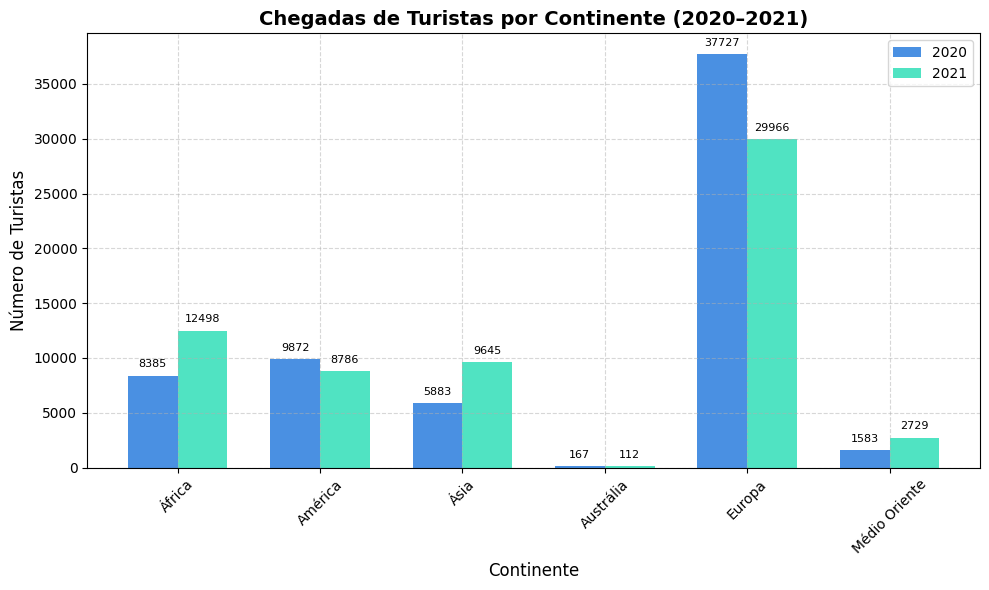

In [79]:
continentes = df['continente'].unique()

chegadas_2020 = df[df['ano'] == 2020].set_index('continente').reindex(continentes)['chegadas_turistas'].fillna(0).values
chegadas_2021 = df[df['ano'] == 2021].set_index('continente').reindex(continentes)['chegadas_turistas'].fillna(0).values

x = np.arange(len(continentes))
largura = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - largura/2, chegadas_2020, largura, label='2020', color='#4A90E2')
plt.bar(x + largura/2, chegadas_2021, largura, label='2021', color='#50E3C2')

plt.title('Chegadas de Turistas por Continente (2020–2021)', fontsize=14, fontweight='bold')
plt.xlabel('Continente', fontsize=12)
plt.ylabel('Número de Turistas', fontsize=12)
plt.xticks(x, continentes, rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Anotações
for i, v in enumerate(chegadas_2020):
    plt.text(i - largura/2, v + max(chegadas_2020.max(), chegadas_2021.max())*0.02, f'{int(v)}', ha='center', fontsize=8)
for i, v in enumerate(chegadas_2021):
    plt.text(i + largura/2, v + max(chegadas_2020.max(), chegadas_2021.max())*0.02, f'{int(v)}', ha='center', fontsize=8)

plt.tight_layout()
plt.show()


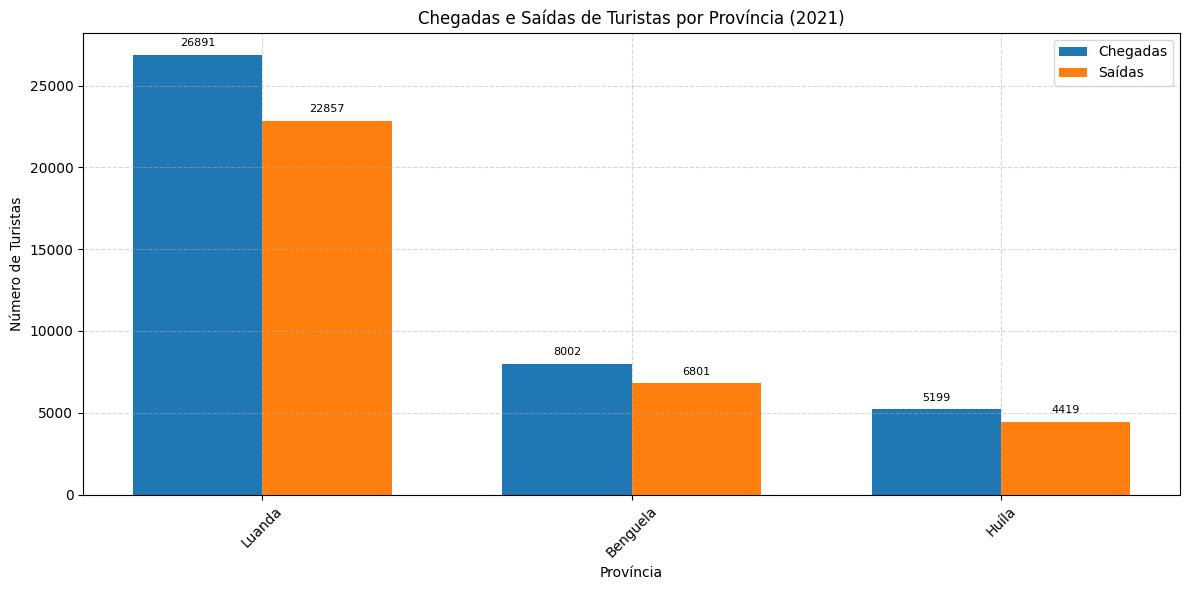

In [80]:
# 3.2 Chegadas e saídas por província (2021)
provincias = artigo['provincia'].unique()
dados_2021 = artigo[artigo['ano'] == 2021]
chegadas = dados_2021.set_index('provincia').reindex(provincias)['chegadas_turistas'].fillna(0).values
saidas = dados_2021.set_index('provincia').reindex(provincias)['saidas_turistas'].fillna(0).values

x = np.arange(len(provincias))
plt.figure(figsize=(12,6))
plt.bar(x - largura/2, chegadas, largura, label='Chegadas')
plt.bar(x + largura/2, saidas, largura, label='Saídas')
plt.title('Chegadas e Saídas de Turistas por Província (2021)')
plt.xlabel('Província')
plt.ylabel('Número de Turistas')
plt.xticks(x, provincias, rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
for i, v in enumerate(chegadas):
    plt.text(i - largura/2, v + max(chegadas.max(), saidas.max())*0.02, f'{int(v)}', ha='center', fontsize=8)
for i, v in enumerate(saidas):
    plt.text(i + largura/2, v + max(chegadas.max(), saidas.max())*0.02, f'{int(v)}', ha='center', fontsize=8)
plt.tight_layout()
plt.show()


In [82]:
# 4.1 Preparar dados agregados por ano (soma de todos continentes/províncias)
agg_por_ano = df.groupby('ano')[['chegadas_turistas', 'saidas_turistas']].sum().reset_index()

print('\n--- Agregado por ano (continentes) ---')
print(agg_por_ano)

# Usaremos 'ano' como variável explicativa simples (X) e 'chegadas_turistas' como target (y)
X = agg_por_ano[['ano']].values
y = agg_por_ano['chegadas_turistas'].values

# 4.2 Modelos: Regressão Linear e RandomForest
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=42)
}



--- Agregado por ano (continentes) ---
    ano  chegadas_turistas  saidas_turistas
0  2019              79000            66950
1  2020              63617            53050
2  2021              63736            54110
3  2022              66930            57550


In [83]:
results = {}
if len(X) >= 3:
    tscv = TimeSeriesSplit(n_splits=3)
else:
    tscv = None  # Desativa a validação cruzada

for name, model in models.items():
    if name not in results:
        results[name] = {}

    # Só faz validação cruzada se possível
    if tscv is not None:
        scores = cross_val_score(model, X, y, cv=tscv, scoring='r2')
        results[name].update({
            'r2_cv_mean': scores.mean(),
            'r2_cv_std': scores.std()
        })

    # Treina com todos os dados
    model.fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    results[name].update({
        'r2_insample': r2,
        'rmse_insample': rmse
    })

print("\n--- Resultados dos modelos (agregado nacional) ---")
print(results)


--- Resultados dos modelos (agregado nacional) ---
{'LinearRegression': {'r2_cv_mean': np.float64(nan), 'r2_cv_std': np.float64(nan), 'r2_insample': 0.40928642178654584, 'rmse_insample': np.float64(4847.621806102392)}, 'RandomForest': {'r2_cv_mean': np.float64(nan), 'r2_cv_std': np.float64(nan), 'r2_insample': 0.7932988189568004, 'rmse_insample': np.float64(2867.5548423188425)}}



--- Previsões (2022-2025) por modelo ---
LinearRegression -> [62907, 59298, 55688, 52079]
RandomForest -> [65754, 65754, 65754, 65754]


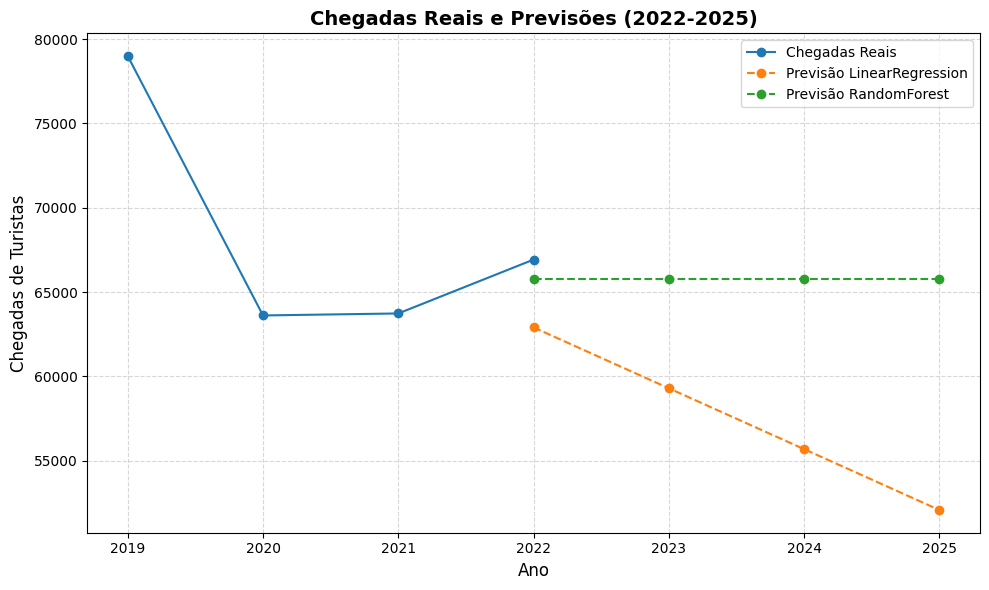

In [85]:

# 4.3 Previsões (2022-2025)
anos_futuros = np.arange(2022, 2026).reshape(-1,1)
previsoes = {}

for name, model in models.items():
    previsoes[name] = model.predict(anos_futuros)

print('\n--- Previsões (2022-2025) por modelo ---')
for name, preds in previsoes.items():
    print(name, '->', [int(p) for p in preds])

# Visualiza tendência e previsões
plt.figure(figsize=(10,6))
plt.plot(agg_por_ano['ano'], agg_por_ano['chegadas_turistas'], 'o-', label='Chegadas Reais')

for name, preds in previsoes.items():
    plt.plot(np.arange(2022,2026), preds, marker='o', linestyle='--', label=f'Previsão {name}')

plt.title('Chegadas Reais e Previsões (2022-2025)', fontsize=14, fontweight='bold')
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Chegadas de Turistas', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [100]:
# 5) Previsões por província (exemplo: ajustar modelo para cada província)
# ---------------------------
prov_models = {}
anos_future = np.arange(2022, 2026)
prov_previsoes = {}

for prov in artigo['provincia'].unique():
    sub = artigo[artigo['provincia'] == prov].sort_values('ano')
    if sub.shape[0] < 2:
        # Sem dados suficientes para modelo
        continue
    Xprov = sub[['ano']].values
    yprov = sub['chegadas_turistas'].values
    # usa LinearRegression por simplicidade (pode testar RandomForest se houver mais pontos)
    m = LinearRegression()
    m.fit(Xprov, yprov)
    prov_models[prov] = m
    prov_previsoes[prov] = m.predict(anos_future.reshape(-1,1))

# Mostra algumas previsões de exemplo
print('\n--- Previsões por província (exemplo 2022-2025) ---')
for prov, preds in list(prov_previsoes.items())[:10]:
    print(prov, '->', [int(p) for p in preds])



--- Previsões por província (exemplo 2022-2025) ---
Luanda -> [27719, 27445, 27171, 26897]
Benguela -> [8422, 8551, 8679, 8808]
Huíla -> [5359, 5399, 5439, 5478]


In [97]:
# Dados nacionais agregados por ano
agg_por_ano = df.groupby('ano')[['chegadas_turistas','saidas_turistas']].sum().reset_index()

# Dados por província (últimos anos)
prov_por_ano = artigo[['ano','provincia','chegadas_turistas','saidas_turistas']]


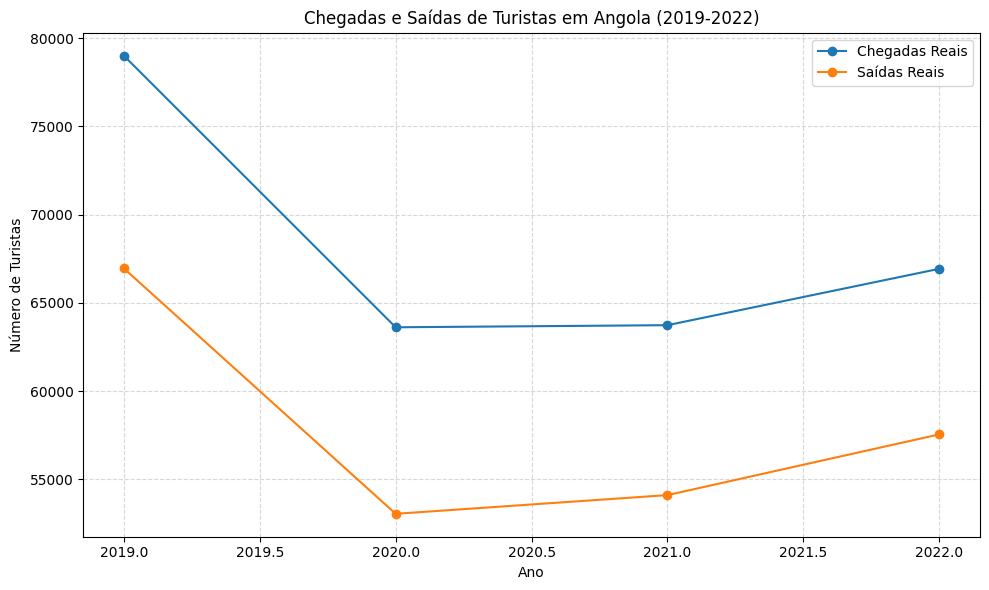

In [99]:
plt.figure(figsize=(10,6))
plt.plot(agg_por_ano['ano'], agg_por_ano['chegadas_turistas'], 'o-', label='Chegadas Reais')
plt.plot(agg_por_ano['ano'], agg_por_ano['saidas_turistas'], 'o-', label='Saídas Reais')
plt.title("Chegadas e Saídas de Turistas em Angola (2019-2022)")
plt.xlabel("Ano")
plt.ylabel("Número de Turistas")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


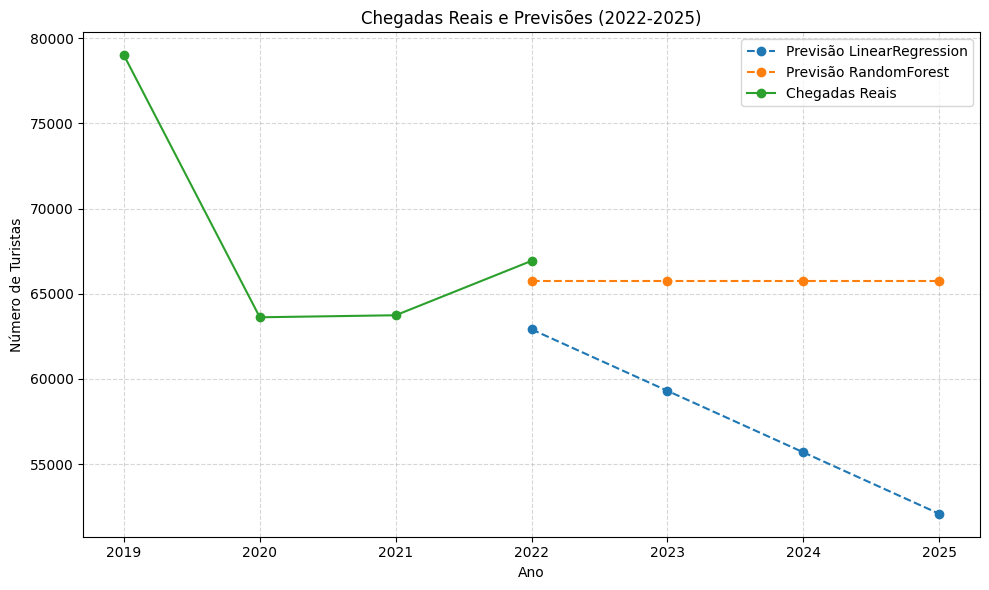

In [102]:
anos_futuros = np.arange(2022, 2026)  # 1D array: 2022,2023,2024,2025

plt.figure(figsize=(10,6))

# Plota previsões por modelo
for name, preds in previsoes.items():
    plt.plot(anos_futuros, preds, marker='o', linestyle='--', label=f'Previsão {name}')

# Plota dados reais agregados
plt.plot(agg_por_ano['ano'], agg_por_ano['chegadas_turistas'], 'o-', label='Chegadas Reais')

plt.title("Chegadas Reais e Previsões (2022-2025)")
plt.xlabel("Ano")
plt.ylabel("Número de Turistas")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


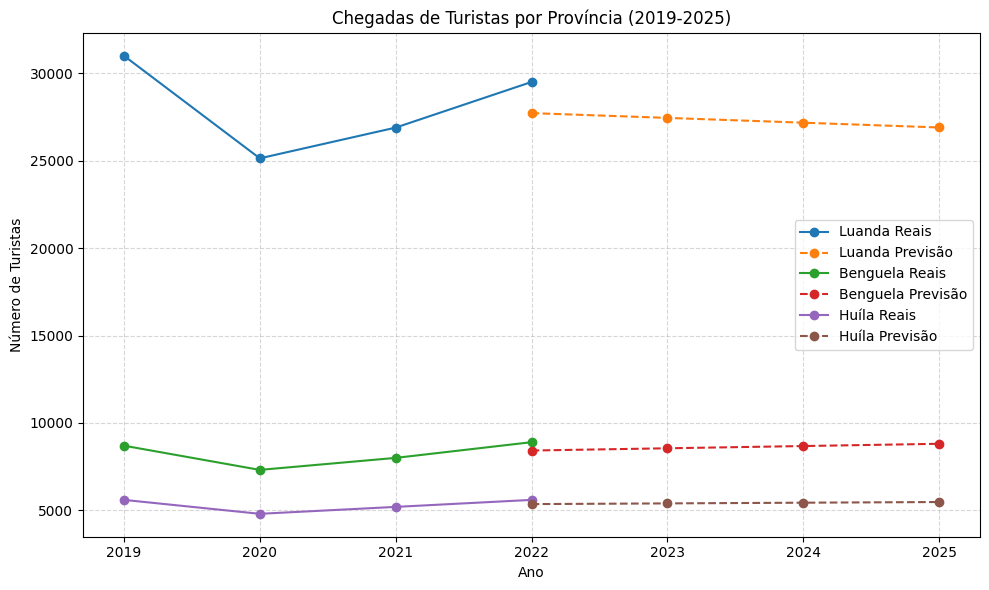

In [103]:
# Lista de províncias que queremos mostrar
prov_selec = ['Luanda','Benguela','Huíla']

# Dicionário com previsões por província
previsoes_prov = {
    'Luanda': [27719, 27445, 27171, 26897],
    'Benguela': [8422, 8551, 8679, 8808],
    'Huíla': [5359, 5399, 5439, 5478]
}

plt.figure(figsize=(10,6))

for prov in prov_selec:
    # Dados reais por província
    dados = prov_por_ano[prov_por_ano['provincia']==prov]
    plt.plot(dados['ano'], dados['chegadas_turistas'], 'o-', label=f'{prov} Reais')
    
    # Previsões por província
    plt.plot(np.arange(2022,2026), previsoes_prov[prov], '--', marker='o', label=f'{prov} Previsão')

plt.title("Chegadas de Turistas por Província (2019-2025)")
plt.xlabel("Ano")
plt.ylabel("Número de Turistas")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [104]:
# 6) Observações finais e salvamento
# ---------------------------
# Salva tabela com previsões agregadas para facilitar relatório
out = pd.DataFrame({'ano': np.arange(2022,2026)})
for name, preds in previsoes.items():
    out[f'previsao_{name}'] = [int(p) for p in preds]

out.to_csv('previsoes_chegadas_2022_2025.csv', index=False)
print('\nArquivo "previsoes_chegadas_2022_2025.csv" salvo no diretório atual.')



Arquivo "previsoes_chegadas_2022_2025.csv" salvo no diretório atual.
